<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/Problem_set/Naive_Bayes_MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes classifiers
Based on sec 18.9 of http://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html.

We show how to implement Naive Bayes classifiers from scratch.
We use binary features, and 2 classes.



In [1]:
%%capture
!pip install gitpython

## Get MNIST Data
- download png mnist from Sebastian Raschka's repo
- visualize image label pairs

In [2]:
import os
from git import Repo

if not os.path.exists('mnist-pngs'):
    Repo.clone_from("https://github.com/rasbt/mnist-pngs", "mnist-pngs")

In [19]:
import imageio
from pathlib import Path
image_paths = list(Path('/content/mnist-pngs/train').rglob('*.png'))
image_labels = [path.parent.parts[-1] for path in image_paths]


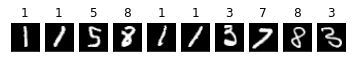

In [20]:
import matplotlib.pyplot as plt
import numpy as np

NUM_FIGS = 10
fig, axs = plt.subplots(1,NUM_FIGS)
for i in range(NUM_FIGS):
  random_index = np.random.randint(low=0,high=len(image_paths))
  img = plt.imread(image_paths[random_index])
  axs[i].imshow(img,cmap='gray')
  axs[i].set_title(image_labels[random_index])
  axs[i].set_xticks([])
  axs[i].set_yticks([])

As shown in above figure, the image consists of binary images of hand written digits from 0 to 9. Corresponding image labels are provided as training labels.

## Training a Naive Bayes Classifier

- obtain $P(\mathcal{Y}=y)$ for $y \in \{0,1,2,\ldots,9\}$
- obtain $P(\mathcal{X}=x|\mathcal{Y}=y)$ for $y \in \{0,1,2,\ldots,9\}$

In [40]:
from collections import Counter

labels = np.unique(image_labels)
num_labels = len(labels)

label_prevalence = Counter(image_labels)
# convert a dict into a vector/matrix notation and normalize to (0,1) obtaining probability
n_y = np.zeros(num_labels)
for y in range(num_labels):
  n_y[y] = label_prevalence[str(y)]
P_y = n_y / n_y.sum()
print(f'Label Count {label_prevalence}')
with np.printoptions(precision=2):
  print(f'Label Probability {P_y}')

Label Count Counter({'1': 6742, '7': 6265, '3': 6131, '2': 5958, '9': 5949, '0': 5923, '6': 5918, '8': 5851, '4': 5842, '5': 5421})
Label Probability [0.1  0.11 0.1  0.1  0.1  0.09 0.1  0.1  0.1  0.1 ]


In [59]:
# Generate a (K,?,28,28) numpy array where K represents labels, N is the number of samples
K = num_labels
N = len(image_paths)
mnist_train = []
image_arrays = np.array([imageio.imread(path)/255.0 for path in image_paths])
image_arrays = image_arrays > 0.5
for y in range(K):
  images_y= image_arrays[np.where(np.array(image_labels) == str(y))]
  mnist_train.append(images_y)



**Aggregating the images into a tensor will make it easier to run vectorized operation:**

- obtain $P(\mathcal{X}=x|\mathcal{Y}=y)$ for $y \in \{0,1,2,\ldots,9\}$

In [64]:
n_x = np.zeros((K,*img.shape))
for y in range(K):
  n_x[y] = mnist_train[y].sum(axis=0)
# we had to use add-one smoothing to avoid DivideByZero error
P_xy = (n_x + 1) / (n_y + 2).reshape(10,1,1)
print(P_xy.shape)

(10, 28, 28)


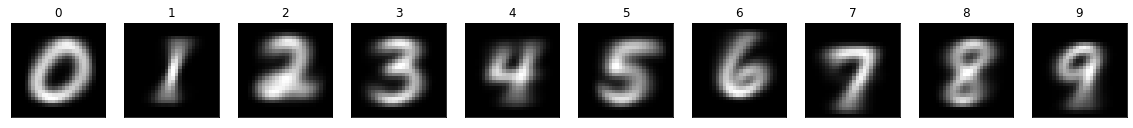

In [65]:
NUM_FIGS = 10
fig, axs = plt.subplots(1,NUM_FIGS,figsize=(20,40))
for i in range(NUM_FIGS):
  img = P_xy[i]
  axs[i].imshow(img,cmap='gray')
  axs[i].set_title(i)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

## Testing the Naive Bayes Classifier
- obtain $P(\mathcal{Y}=y| \mathcal{X}=x)$ for $y \in \{0,1,2,\ldots,9\}$

In [70]:
# we convert probabilities into log-probabilities
# This allows us to sum the log-probabilities instead of multiplying probabilities
# multiplying lots of probabilities is unstable, since the floating point representation is not exact
log_P_xy = np.log(P_xy)
log_P_xy_neg = np.log(1 - P_xy)
log_P_y = np.log(P_y)

def bayes_predict_stable(x):
  x = np.expand_dims(x,0) # (28,28) -> (1,28,28)
  p_xy = log_P_xy * x + log_P_xy_neg * (1 - x) # select the 0 and 1 pixels
  p_xy = p_xy.reshape(10,-1).sum(axis=1) # this is where naive assumption is realized
  return p_xy + log_P_y

def predict(X):
  return [np.argmax(bayes_predict_stable(x)) for x in X]

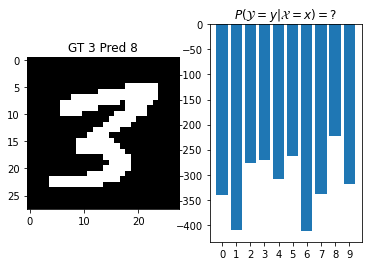

In [98]:
test_image_paths = list(Path('/content/mnist-pngs/test').rglob('*.png'))
test_image_labels = [path.parent.parts[-1] for path in test_image_paths]

# take a test image
test_img = imageio.imread(test_image_paths[0])/255.0
test_img = test_img > 0.5
test_p_y = bayes_predict_stable(test_img)

fig,ax = plt.subplots(1,2)
ax[0].imshow(test_img,cmap='gray')
ax[0].set_title(f'GT {test_image_labels[0]} Pred {np.argmax(test_p_y)}')
ax[1].bar(labels,test_p_y)
ax[1].set_title(r'$P(\mathcal{Y}=y|\mathcal{X}=x)=?$')
plt.show()

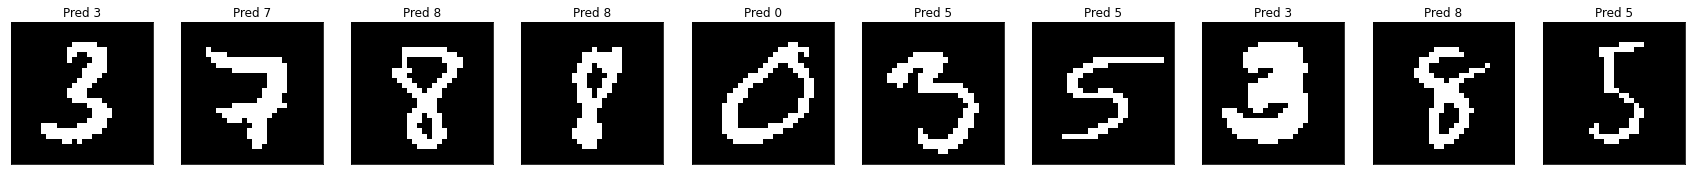

In [99]:
N = 10
fig,ax = plt.subplots(1,N,figsize=(30,30))
for i in range(N):
  random_index = np.random.randint(low=0,high=len(test_image_paths))
  test_img = imageio.imread(test_image_paths[random_index])/255.0
  test_img = test_img > 0.5
  test_p_y = bayes_predict_stable(test_img)
  ax[i].imshow(test_img,cmap='gray')
  ax[i].set_title(f'Pred {np.argmax(test_p_y)}')
  ax[i].set_xticks([])
  ax[i].set_yticks([])

In [100]:
pred_labels = []
for i in range(len(test_image_paths)):
  test_img = imageio.imread(test_image_paths[i])/255.0
  test_img = test_img > 0.5
  test_p_y = bayes_predict_stable(test_img)  
  pred_label = np.argmax(test_p_y)
  pred_labels.append(pred_label)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       980
           1       0.89      0.96      0.92      1135
           2       0.89      0.81      0.85      1032
           3       0.79      0.83      0.81      1010
           4       0.83      0.81      0.82       982
           5       0.79      0.73      0.76       892
           6       0.89      0.89      0.89       958
           7       0.92      0.84      0.88      1028
           8       0.77      0.78      0.77       974
           9       0.75      0.84      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



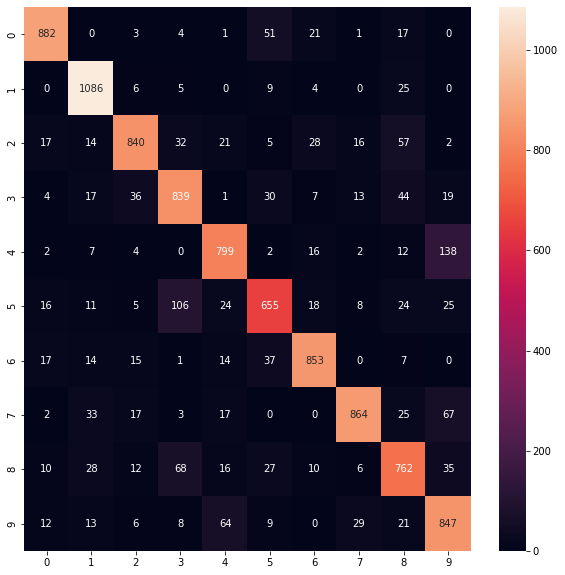

In [118]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
pred_labels = np.array(pred_labels)
test_image_labels = np.array([int(i) for i in test_image_labels])
accuracy = float((pred_labels == test_image_labels).sum()) / len(test_image_labels)
cm = confusion_matrix(test_image_labels,pred_labels)
print(classification_report(test_image_labels, pred_labels))

plt.figure(figsize=(10,10))
sn.heatmap(cm,annot=True,fmt='g')
plt.show()
